In [26]:
import jax
import jax.numpy as jnp
from jax import jit, vmap

import matplotlib.pyplot as plt
from cProfile import Profile
import time


In [27]:
def correlate_weiner_process(X, L, dt):
    return jnp.sqrt(dt) * jnp.einsum("ab,bc->ac", L, X)

def update_process(xt, dt, alpha, mu, sigma, dZt):
    dxt_drift = alpha * (mu - xt) * dt
    dxt_stochastic_variation = sigma * jnp.sqrt(xt) * dZt

    return xt + dxt_drift + dxt_stochastic_variation

def generate_process(x0, dt, alpha, mu, sigma, dZ):
    x = jnp.zeros(len(dZ))
    x = x.at[0].set(x0)
    for i in range(1, len(dZ)):
        x = x.at[i].set(update_process(x[i-1], dt, alpha, mu, sigma, dZ[i-1]))
    
    return x

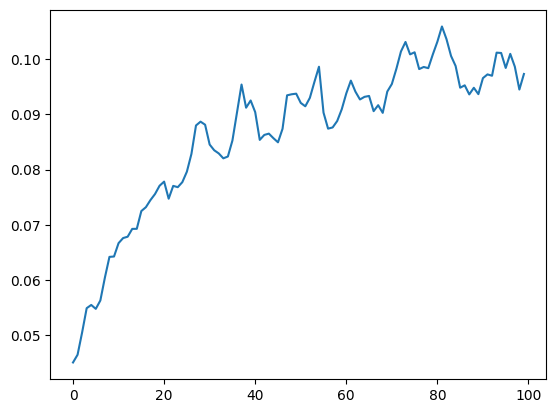

In [28]:
n_years = 100
dt = 1 / 12

n_factors = 2

n_runs = 1000
key = jax.random.PRNGKey(42)
X = jax.random.normal(key=key, shape=(n_factors, n_years))

rho = - 0.739
weiner_sigma = jnp.array([[1, rho], [rho, 1]])
weiner_L = jnp.linalg.cholesky(weiner_sigma).T

dZ = correlate_weiner_process(X, weiner_L, dt)

# Initial values
x_10 = 0.0228
x_20 = 0.0809
# Parameters
a_1 = 1.0682
m_1 = 0.0546
s_1 = 0.0412
a_2 = 0.0469
m_2 = 0.0778
s_2 = 0.0287


with Profile() as profile:
    x_1 = generate_process(x_10, dt, a_1, m_1, s_1, dZ[0])
    x_2 = generate_process(x_20, dt, a_2, m_2, s_2, dZ[1])

    phi = 0.045 - (x_10 + x_20)
    n = phi + x_1 + x_2
    # print(profile.print_stats(sort='tottime'))

plt.plot(n)


In [31]:
n_runs = 10000

n_years = 100
dt = 1 / 12

n_factors = 2

# Initial values
x = jnp.array([0.0228, 0.0809])
# Parameters
a = jnp.array([1.0682, 0.0469])
m = jnp.array([0.0546, 0.0778])
s = jnp.array([0.0412, 0.0287])

# run all runs simultaneously
key = jax.random.PRNGKey(57)
X = jax.random.normal(key=key, shape=(n_runs, n_factors, int(n_years / dt)))

rho = 0.739

def generate_runs(n_runs, n_years, dt, x, a, m, s, rho):
    weiner_sigma = jnp.array([[1, rho], [rho, 1]])

    weiner_L = jnp.linalg.cholesky(weiner_sigma).T
    
    # use vmap to get all dZs
    dZ = vmap(correlate_weiner_process, in_axes=(0, None, None))(X, weiner_L, dt)
    x1 = vmap(generate_process, in_axes=(None, None, None, None, None, 0))(x[0], dt, a[0], m[0], s[0], dZ[:, 0,:])
    x2 = vmap(generate_process, in_axes=(None, None, None, None, None, 0))(x[1], dt, a[1], m[1], s[1], dZ[:, 1,:])

    phi = 0.045 - (x[0] + x[1])
    n = phi + x1 + x2

    # plt.plot(n.T)

generate_runs_jit = jit(generate_runs)
start_time = time.time()
generate_runs_jit(n_runs, n_years, dt, x, a, m, s, rho)
end_time = time.time()
print("Simulation time:", end_time - start_time, "seconds")


Simulation time: 7.193864822387695 seconds
